In [16]:
class Gibbs_free_energy:
    """Based on a predetermined bulk solution, this code can calculate the gibbs free energy of various reactions. Made by Dylan Verburg in april 2022"""
    def __init__(self, bulk_solution):
        import numpy as np
        import matplotlib.pyplot as plt
        import pandas as pd
        #bulk solution is denoted in pandas dataframe
        #entropies are based on the file below
        self.energies = pd.read_csv('entropy_enthalpy_table.csv', skiprows=[1], skipinitialspace=True, index_col=0)
        self.R = 8.314/1000 #kJ/mol K
        self.Ts = 298.15 #K
        self.bulk_solution = bulk_solution  #assume this to be a dataframe
    
### interface functions ###
    def read_reaction(self, reaction, undefined_concentrations, warnings = True):
        #undefined_concentrations = 1
        #initialize the lists
        stoichiometry = np.array([0])
        compound = np.array(['0'])
        concentration = np.array([0])
        gas = np.array([0])
        
        
        reaction_sides = reaction.split('-->') #split right and left hand side of equation
        
        for i in range(len(reaction_sides)): #this is for the two sides of the equation, but more would work aswell
            reaction_compounds = reaction_sides[i].split(' + ') #split compounds
            
            for j in range(len(reaction_compounds)):
                reaction_pure_compound = reaction_compounds[j].split('*') #see if there is one or more mole of the compound in the reaction
                
                if(len(reaction_pure_compound) == 1): #if there is nothing written in front of the material, assume it should be 1 and assume concentration to be 1
                    reaction_pure_compound = [1.0, reaction_compounds[j]]
               
                stoichiometry = np.append(stoichiometry, float(reaction_pure_compound[0]) * (-1.0)**(i + 1)) #make the stoichiometric variable positive or negative based on the side of the equation
                compound = np.append(compound, reaction_pure_compound[1].replace(" ", ""))
                
                gas = np.append(gas, reaction_pure_compound[1].find("(g)") <= 0) #is this a gas or not
                #add a concentration provided in the bulk, and prevent errors if it is not provided
                try:
                    concentration = np.append(concentration, self.bulk_solution.loc[compound[-1]])
                except:
                    concentration = np.append(concentration, undefined_concentrations)
                    if warnings == True:
                        print(f'No concentration for {reaction_pure_compound[1]} was found. It was set to {undefined_concentrations}')
                
        #put everything in a pandas dataframe for easier lookup accros tables
        reaction_full = pd.DataFrame(list(zip(stoichiometry, concentration)), index = compound, columns = ['Stoichiometry','Concentration'], dtype = float)
        
        reaction_full["Gas"] = gas
        reaction_full = reaction_full.drop('0')
        
        return reaction_full
    
    def check_reaction(self, reaction):
        #This function checks if the provided reactions are balanced
        reaction_matrix = self.read_reaction(reaction, 1, warnings = False)
        #define some lists and the list to work on
        compound_list = []
        value_list = []
        
        #iterate through the compounds in the reaction, drop the phase and the charge of these aswell
        for compound in range(len(reaction_matrix)):
            find = reaction_matrix.index[compound]  
            #drop phase
            b = find.find('(')
            text = find[0:b]
            
            #drop charge and find ion balance, also for multivalent ions
            if text.find('-') > 0 or text.find('+') > 0:
                
                char_sym_ind = max(text.find('-'), text.find('+'))

                charge = text[char_sym_ind:]
                #count the charge balance contribution
                name = 'e'
                try: 
                    e = float(charge[1]) * reaction_matrix.Stoichiometry[compound]
                except: 
                    e = reaction_matrix.Stoichiometry[compound]
                
                #this allows 2*O2- + 4* H+ --> 2* H2O to have balanced charges
                if(charge[0] == '-'):
                    e *= -1
                compound_list.append(name) 
                value_list.append(e)
                
                #scrub the charge for further analysis
                text = text[0:char_sym_ind]
                
            #this takes the scrubbed compounds and finds the capital letters, this allows for simple compounds like 'H', for hydrogen, but also 'Ca' for calcium to be balanced
            d = ''.join(' ' + char if char.isupper() else char.strip() for char in text).strip().split(" ")
            #iterate through all these parts of a compound, some like CO2 have no number next to the C, 
            #the try, except structure, deals with this and appends the stoichiometric value of a compound to a list, as well as the compound itself
            for i in range(len(d)):
                try: 
                    e = float(d[i][-1]) * reaction_matrix.Stoichiometry[compound]
                    name = d[i][0:-1]
                except: 
                    e = reaction_matrix.Stoichiometry[compound]
                    name = d[i][:]
                compound_list.append(name) 
                value_list.append(e)
                
        #once all compounds have been added, the unique compounds are put in a list to which a parralel list for bookkeeping is made
        unique = list(set(compound_list))
        values_unique = [0] * len(unique)

        #find the index of the compound in the unique list, add the stoichiometry to the values list
        for p in range(len(compound_list)):
            index = unique.index(compound_list[p])
            values_unique[index] += value_list[p]
        
        #find all non_zero values in the list, these are thus not balanced
        missing_index = np.nonzero(values_unique)[0]
        
        #give human readable output for both the case of balance, and impabalnce
        if len(missing_index) > 0:
            print(f'Non balanced reaction {reaction} ,is missing:')
            for i in range(len(missing_index)):
                print(f'{values_unique[missing_index[i]]} {unique[missing_index[i]]}')
        else: print('Balanced reaction')
        
### Thermodynamic functions ###
    def define_G(self, reaction_matrix):
        
        #This function gives the initial G and H values
        #initialize
        dH = 0
        dG = 0
        
        #find in provided matrix of gibbs energies
        for i in range(len(reaction_matrix)):
            Gibbs_values = self.energies.loc[reaction_matrix.index[i], :] #find the dH and dS values
            
            #combine the energies to gain a reaction energy
            dH += reaction_matrix.Stoichiometry[i] * float(Gibbs_values[0])
            dG += reaction_matrix.Stoichiometry[i] * float(Gibbs_values[2])   
            #print(dG, dH)
        return dG, dH
    
    def T_C_comp_linear(self, reaction_matrix, d_G0S, d_H0S, T):
        #T compensation for a range of T in K, as well as concentration compensation based on the bulk solution and gasses       
        #concentration compensation for gasses and non-gasses on the same range of T        
        reaction_matrix["mult"] = reaction_matrix.Stoichiometry * np.log(reaction_matrix.Concentration) 
        
        non_gasses = reaction_matrix.mult[reaction_matrix.Gas > 0].sum(axis=0)
        gasses = reaction_matrix.mult[reaction_matrix.Gas == 0].sum(axis=0) 
        
        #gasses should be in b but that doesn't seem to work
        #This is based on shuffeling the Gibbs free energy calculation into making it a linear function in T, provided the concentrations do not change
        a = self.R * (gasses + non_gasses) + (d_G0S - d_H0S) / self.Ts
        b =  d_H0S #+ gasses
        
        # coeficients for certain concentrations, this makes simulating a temprature range more memory efficient
        return a , b

    def give_for_T(self, reaction, T = [-1], undefined_concentrations = 1, warnings = True):
        #allows the user to ask for the gibbs energy at a certain temprature, or range of tempratures
        reaction_matrix = self.read_reaction(reaction, undefined_concentrations, warnings)
        
        #provides easy way to provide dG for standard temprature (298.15K), just used for easy interaction
        if(T[-1]<0):
            T = self.Ts
        
        #find the standard T, G and H values
        dG, dH = self.define_G(reaction_matrix)
        #feed these to the T and concentration compensation function
        a, b = self.T_C_comp_linear(reaction_matrix, dG, dH, T)
        #create the array based on the temprature fed into the function
        dGT = a * np.array(T) + b
        return dGT
    
    def thin_film(self, reaction_matrix, T, C_diff = 0.1, steps = 11):
        #Basic code to resemble difussion driven change in substrate and products by changing the concentration over time  
        a_row = []
        b_row = []
        c_row = []
        concentration_row = []
        
        Concentrations= reaction_matrix.Concentration.tolist()
        #molar difference based on a percentage of the first compound
        diff = (reaction_matrix.Concentration.iloc[0] * C_diff / reaction_matrix.Stoichiometry[0]) * reaction_matrix.Stoichiometry
        concentration_row.append(Concentrations)
        
        d_G0s, d_H0s = self.define_G(reaction_matrix)
  
        for i in range(steps):
            a, b = self.T_C_comp_linear(reaction_matrix, d_G0s, d_H0s, T)
            
            a_row.append(a)
            b_row.append(b)
            c_row.append(round(C_diff * i, 3))
            
            #change the concentration of reaction products and substrates, the idea is to decrease the concentration with 10% (C_diff) per step (steps) for the whole reaction, thus stoichiometry plays a role
            Concentrations -= diff
            #prevent negative concentrations
            Concentrations[Concentrations < 0] = 1e-11
            
            concentration_row.append(Concentrations.tolist())
            reaction_matrix.Concentration = Concentrations
            
        return np.array(a_row), np.array(b_row), np.array(c_row), concentration_row

### Visual functions ###    
    def plot_for_T(self, reaction, Tmin = 0, Tmax = 500, undefined_concentrations = 1, warnings = True, title = ""):
        T = np.linspace(Tmin, Tmax, 50)
        dGT = self.give_for_T(reaction, T, undefined_concentrations, warnings)
        
        if title == "":
            title = reaction
        
        #plt.figure()
        plt.title(f'Gibbs free energy for {title}.')
        #plt.plot((T[0], T[-1]),(-20, -20), label = 'low energy quantum -20 kJ/mol') #based on Müller et al 2017, less is possible, but no figure is given for this.
        plt.plot(T, dGT, label = f"{title}")
        plt.ylabel("Gibbs free energy of reaction [kJ/Mol]")
        plt.xlabel("Temprature [K]")
        #plt.legend()
            
    def thin_film_simulation(self, reaction, Tmin = 0, Tmax = 500, C_diff = 0.1, steps = 11, undefined_concentrations = 1, warnings = True, title = "", show = "show"):
        """show: table, save, show respectavily for generating a table for use in LaTeX, saving the plots and showing everything on screen"""
        
        T = np.linspace(Tmin, Tmax, 50)
        reaction_matrix = self.read_reaction(reaction, undefined_concentrations, warnings = warnings)
        a, b, sim_range, concentration_row = self.thin_film(reaction_matrix, T, C_diff, steps)
        
        dGT= []
        for i in range(len(a)):
            dGT.append(a[i] * T + b[i])
                   
        if title == "":
            title = "thin film" + reaction        
        
        if show == "d_out":
            return dGT
            
        if show == "save": 
            plt.savefig(f'GFE_C_range_{title}.png')
            
        if show == "show":
            plt.figure()
            plt.title(f'Gibbs free energy for {title}.')
            plt.plot((T[0], T[-1]),(-20, -20), label = 'low energy quantum -20 kJ/mol') #based on Müller et al 2017, less is possible, but no figure is given for this.

            for i in range(len(sim_range)):
                plt.plot(T, dGT[i], label = f'{sim_range[i] * 100}% reduction of the first compound.')

            plt.ylabel("Gibbs free energy of reaction [kJ/Mol]")
            plt.xlabel("Temprature [K]")
            plt.legend()
        
            print(f'For {reaction}:')
            plt.show()
            
            print(f"Concentration" , end = '\t')
            print(*list(reaction_matrix.index.values), sep = '\t\t', end = '\t')
            print("Gibbs(T) ")
            
            for i in range(steps):
                print({sim_range[i]}, end = '\t')
                print(*('{:.3e}'.format(x) for x in concentration_row[i]), sep='\t', end = '\t')
                print("{:.3e}".format(a[i]), '* T +', "{:.3e}".format(b[i]))
        
        if show == 'table': #method to generate LaTeX tables form the raw data, to aid the writing process
            print('\\begin{table}[h!]')
            print('\\caption {Exact output for ', end = '')
            print(title, end = '')
            print(', figure: \\ref{fig:GFE_C_range_', end = '')
            print(title, end = '')
            print('}}')
            print('\\label{tab:GFE_C_range_', end = '')
            print( title, end = '')
            print( '}')
            print('\\begin{tabular}{', end = '')
            print((len(reaction_matrix) + 2) * "l", end = '' )
            print( '}')
            print('\\multicolumn{', end = '' )
            print((len(reaction_matrix) + 2), end = '' )
            print('}{l}{For ' , end = '' )
            print(reaction, end = '' )
            print(" :} \\\\")
            #table header
            print(f"Conc. red. [-]" , end = '&')
            print(*list(reaction_matrix.index.values), sep = '&', end = '&')
            print("Gibbs(T)\\\\")
            
            
            for i in range(steps):    
                print(sim_range[i] , end = '&')      
                print(*('{:.3e}'.format(x) for x in concentration_row[i]), sep='&', end = '&')
                print("{:.3e}".format(a[i]), '* T +', "{:.3e}".format(b[i]), '\\\\')
            print("\end{tabular}")
            print("\end{table}")
            print("")

In [17]:
#define bulk solution based on expirimental P-MRA version
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
        
bulk_MRA = np.array([["CO2(g)", 0.951],
                ['N2(g)', 0.0259],
                ['Ar(g)', 0.0194],
                ['O2(g)', 0.0016],
                ['CO(g)', 0.0006],
                ['H2(g)', 1e-7],
                ['CH4(g)', 1e-7], #pP
                ['H2O(l)', 1],
                ["SiO2", 3.00018], #g/L
                ["MgSiO4", 2.000123084],
                ["FeSiO4", 4.61892831],
                ["Fe2O3", 4.61892831],
                ["(Na,Ca)0.33(Al,Mg)2(Si4O10)(OH)2·nH2O", 45.0027694],
                ["Al2Si2O5(OH)4", 6.366917234],
                ["FeCO3", 11.14475363],
                ["Mg5(CO3)4(OH)2*4H2O", 5.000307711],
                ["NO3-", 0.060003693],
                ["C2H3O2-", 1.600098468],
                ])

#list based on Kurth et al. 2020 for the methanogenic reactions
#compounds to be seperated by ' + ', this prevents problems with positively charged compounds. 
reactions = ['4.0 * H2(g) + CO2(g) --> CH4(g) + 2.0 * H2O(l)', 
            '4*HCO2-(aq) + 4*H+(aq) --> CH4(g) + 3*CO2(g) + 2*H2O(l)',
            '2 * C2H5OH(l) + CO2(g) --> 2 * CH3COOH(l) + CH4(g)', #C2H5OH boils at 64C / 337.8K
            'CH3OH(l) + H2(g) --> CH4(g) + H2O(l)',    #CH3OH boils at 64.7C / 337K
            '2 * CH3OH(l) + C2H5OH(l) --> 2*CH4(g) + H2O(l) +  CH3COOH(l) ', #CH3COOH boils at 118C / 391.2K
            '4*CH3OH(l) --> CO2(g) + 3*CH4(g) + 2*H2O(l)',
            'CH3COOH(l) --> CO2(g) + CH4(g)',  
            '4* CO2(g) + 8* H2(g) -->4* H2O(l) + 2* CH3COOH(l)',
            'SO4-2(aq) + 2 * CH2O(aq) --> H2S(g) + 2*HCO3-(aq)',
            '5 * H2(g) + SO4-2(aq) --> H2S(g) + 4 * H2O(l)'
           ]

titles = [ "Hydrogenotrophic methanogenisis",
           "Formate based methylotrophic methanogenisis",
           "Ethanol based methanogenisis",
           "Hydrogen based methylotrophic methanogenisis",
           "Ethanol based methyotrophic methanogenisis",
           "Methylotrophic methanogenisis",
           "Acetoclastic methanogenisis",
           "Acetogenisis",
           'Formaldyhyde based sulphate reduction to sulphur gas',
           'Hydrogenotrophic sulfate reducers'
        ]

#this line can be used for more complex bulk solutions, that are formated in csv from for example PHREEQC
#bulk_MRA = pd.read_csv('bulk_solution.csv', index_col = 'material')

#this line allows the above definition to be used in the class
bulk_MRA = pd.DataFrame(bulk_MRA[:,1], index = bulk_MRA[:,0], columns = ['concentration'])

#create an instance of the gibbs free energy class, in this enviroment multiple reactions can be explored.
MRA = Gibbs_free_energy(bulk_MRA)

For 4.0 * H2(g) + CO2(g) --> CH4(g) + 2.0 * H2O(l):


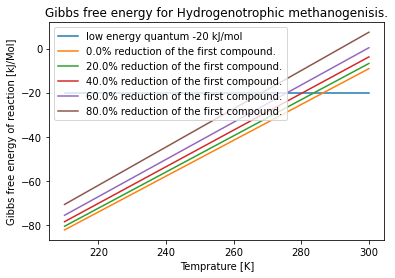

Concentration	H2(g)		CO2(g)		CH4(g)		H2O(l)	Gibbs(T) 
{0.0}	1.000e-07	9.510e-01	1.000e-07	1.000e+00	8.128e-01 * T + -2.530e+02
{0.2}	8.000e-08	9.510e-01	1.050e-07	1.000e+00	8.206e-01 * T + -2.530e+02
{0.4}	6.000e-08	9.510e-01	1.100e-07	1.000e+00	8.306e-01 * T + -2.530e+02
{0.6}	4.000e-08	9.510e-01	1.150e-07	1.000e+00	8.444e-01 * T + -2.530e+02
{0.8}	2.000e-08	9.510e-01	1.200e-07	1.000e+00	8.678e-01 * T + -2.530e+02
For 4*HCO2-(aq) + 4*H+(aq) --> CH4(g) + 3*CO2(g) + 2*H2O(l):


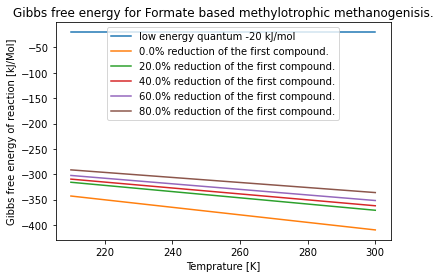

Concentration	HCO2-(aq)		H+(aq)		CH4(g)		CO2(g)		H2O(l)	Gibbs(T) 
{0.0}	1.000e+00	1.000e+00	1.000e-07	9.510e-01	1.000e+00	-7.425e-01 * T + -1.870e+02
{0.2}	8.000e-01	8.000e-01	5.000e-02	1.101e+00	1.100e+00	-6.134e-01 * T + -1.870e+02
{0.4}	6.000e-01	6.000e-01	1.000e-01	1.251e+00	1.200e+00	-5.838e-01 * T + -1.870e+02
{0.6}	4.000e-01	4.000e-01	1.500e-01	1.401e+00	1.300e+00	-5.493e-01 * T + -1.870e+02
{0.8}	2.000e-01	2.000e-01	2.000e-01	1.551e+00	1.400e+00	-4.971e-01 * T + -1.870e+02
For 2 * C2H5OH(l) + CO2(g) --> 2 * CH3COOH(l) + CH4(g):


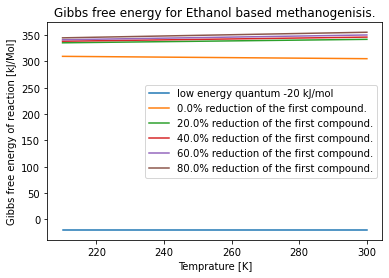

Concentration	C2H5OH(l)		CO2(g)		CH3COOH(l)		CH4(g)	Gibbs(T) 
{0.0}	1.000e+00	9.510e-01	1.000e+00	1.000e-07	-4.940e-02 * T + 3.201e+02
{0.2}	8.000e-01	8.510e-01	1.200e+00	1.000e-01	7.313e-02 * T + 3.201e+02
{0.4}	6.000e-01	7.510e-01	1.400e+00	2.000e-01	8.727e-02 * T + 3.201e+02
{0.6}	4.000e-01	6.510e-01	1.600e+00	3.000e-01	1.008e-01 * T + 3.201e+02
{0.8}	2.000e-01	5.510e-01	1.800e+00	4.000e-01	1.181e-01 * T + 3.201e+02
For CH3OH(l) + H2(g) --> CH4(g) + H2O(l):


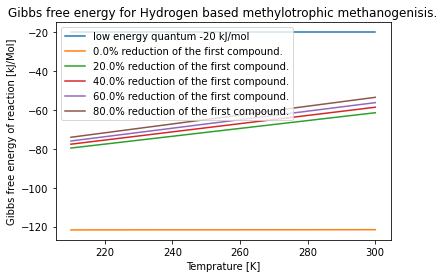

Concentration	CH3OH(l)		H2(g)		CH4(g)		H2O(l)	Gibbs(T) 
{0.0}	1.000e+00	1.000e-07	1.000e-07	1.000e+00	1.345e-03 * T + -1.220e+02
{0.2}	8.000e-01	1.000e-11	2.000e-01	1.200e+00	2.019e-01 * T + -1.220e+02
{0.4}	6.000e-01	1.000e-11	4.000e-01	1.400e+00	2.114e-01 * T + -1.220e+02
{0.6}	4.000e-01	1.000e-11	6.000e-01	1.600e+00	2.192e-01 * T + -1.220e+02
{0.8}	2.000e-01	1.000e-11	8.000e-01	1.800e+00	2.283e-01 * T + -1.220e+02
For 2 * CH3OH(l) + C2H5OH(l) --> 2*CH4(g) + H2O(l) +  CH3COOH(l) :


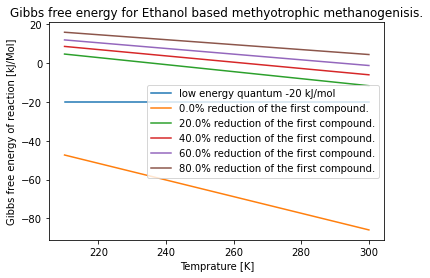

Concentration	CH3OH(l)		C2H5OH(l)		CH4(g)		H2O(l)		CH3COOH(l)	Gibbs(T) 
{0.0}	1.000e+00	1.000e+00	1.000e-07	1.000e+00	1.000e+00	-4.284e-01 * T + 4.258e+01
{0.2}	8.000e-01	9.000e-01	2.000e-01	1.100e+00	1.100e+00	-1.810e-01 * T + 4.258e+01
{0.4}	6.000e-01	8.000e-01	4.000e-01	1.200e+00	1.200e+00	-1.622e-01 * T + 4.258e+01
{0.6}	4.000e-01	7.000e-01	6.000e-01	1.300e+00	1.300e+00	-1.463e-01 * T + 4.258e+01
{0.8}	2.000e-01	6.000e-01	8.000e-01	1.400e+00	1.400e+00	-1.275e-01 * T + 4.258e+01
For 4*CH3OH(l) --> CO2(g) + 3*CH4(g) + 2*H2O(l):


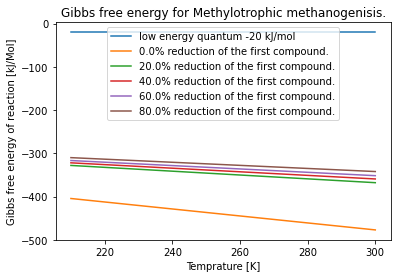

Concentration	CH3OH(l)		CO2(g)		CH4(g)		H2O(l)	Gibbs(T) 
{0.0}	1.000e+00	9.510e-01	1.000e-07	1.000e+00	-8.074e-01 * T + -2.350e+02
{0.2}	8.000e-01	1.001e+00	1.500e-01	1.100e+00	-4.433e-01 * T + -2.350e+02
{0.4}	6.000e-01	1.051e+00	3.000e-01	1.200e+00	-4.146e-01 * T + -2.350e+02
{0.6}	4.000e-01	1.101e+00	4.500e-01	1.300e+00	-3.892e-01 * T + -2.350e+02
{0.8}	2.000e-01	1.151e+00	6.000e-01	1.400e+00	-3.574e-01 * T + -2.350e+02
For CH3COOH(l) --> CO2(g) + CH4(g):


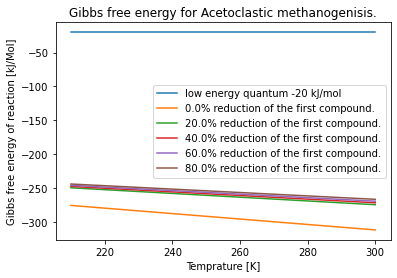

Concentration	CH3COOH(l)		CO2(g)		CH4(g)	Gibbs(T) 
{0.0}	1.000e+00	9.510e-01	1.000e-07	-4.019e-01 * T + -1.913e+02
{0.2}	8.000e-01	1.151e+00	2.000e-01	-2.778e-01 * T + -1.913e+02
{0.4}	6.000e-01	1.351e+00	4.000e-01	-2.684e-01 * T + -1.913e+02
{0.6}	4.000e-01	1.551e+00	6.000e-01	-2.605e-01 * T + -1.913e+02
{0.8}	2.000e-01	1.751e+00	8.000e-01	-2.513e-01 * T + -1.913e+02
For 4* CO2(g) + 8* H2(g) -->4* H2O(l) + 2* CH3COOH(l):


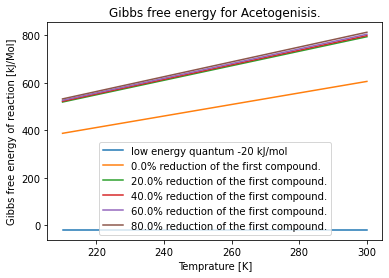

Concentration	CO2(g)		H2(g)		H2O(l)		CH3COOH(l)	Gibbs(T) 
{0.0}	9.510e-01	1.000e-07	1.000e+00	1.000e+00	2.429e+00 * T + -1.232e+02
{0.2}	7.608e-01	1.000e-11	1.190e+00	1.095e+00	3.057e+00 * T + -1.232e+02
{0.4}	5.706e-01	1.000e-11	1.380e+00	1.190e+00	3.073e+00 * T + -1.232e+02
{0.6}	3.804e-01	1.000e-11	1.571e+00	1.285e+00	3.092e+00 * T + -1.232e+02
{0.8}	1.902e-01	1.000e-11	1.761e+00	1.380e+00	3.120e+00 * T + -1.232e+02
For SO4-2(aq) + 2 * CH2O(aq) --> H2S(g) + 2*HCO3-(aq):


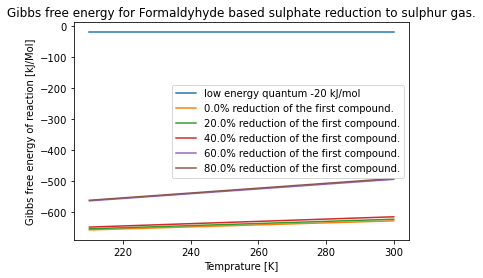

Concentration	SO4-2(aq)		CH2O(aq)		H2S(g)		HCO3-(aq)	Gibbs(T) 
{0.0}	1.000e+00	1.000e+00	1.000e+00	1.000e+00	3.251e-01 * T + -7.256e+02
{0.2}	8.000e-01	6.000e-01	1.200e+00	1.400e+00	3.426e-01 * T + -7.256e+02
{0.4}	6.000e-01	2.000e-01	1.400e+00	1.800e+00	3.687e-01 * T + -7.256e+02
{0.6}	4.000e-01	1.000e-11	1.600e+00	2.200e+00	7.709e-01 * T + -7.256e+02
{0.8}	2.000e-01	1.000e-11	1.800e+00	2.600e+00	7.804e-01 * T + -7.256e+02
For 5 * H2(g) + SO4-2(aq) --> H2S(g) + 4 * H2O(l):


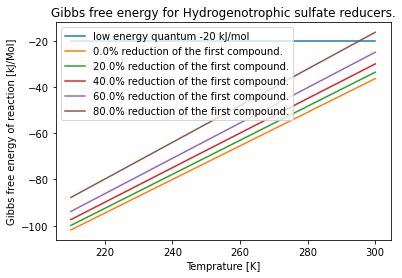

Concentration	H2(g)		SO4-2(aq)		H2S(g)		H2O(l)	Gibbs(T) 
{0.0}	1.000e-07	1.000e+00	1.000e+00	1.000e+00	7.278e-01 * T + -2.547e+02
{0.2}	8.000e-08	1.000e+00	1.000e+00	1.000e+00	7.371e-01 * T + -2.547e+02
{0.4}	6.000e-08	1.000e+00	1.000e+00	1.000e+00	7.491e-01 * T + -2.547e+02
{0.6}	4.000e-08	1.000e+00	1.000e+00	1.000e+00	7.659e-01 * T + -2.547e+02
{0.8}	2.000e-08	1.000e+00	1.000e+00	1.000e+00	7.947e-01 * T + -2.547e+02


In [32]:
#example calculations

for i in range(len(reactions)):
    #MRA.check_reaction(reactions[i])
    MRA.thin_film_simulation(reactions[i], title = titles[i], steps = 5, C_diff = 0.2, Tmin = 210, Tmax = 300, warnings = False, show = 'show' )
    #MRA.plot_for_T(reactions[i], title = titles[i], Tmin = 210, Tmax = 300)
    
#plt.legend(loc = "center left")
#MRA.check_reaction(reactions[0])
#MRA.give_for_T(reaction, T = [308.15])

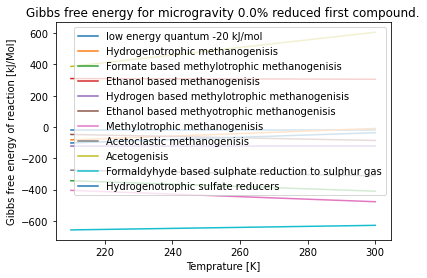

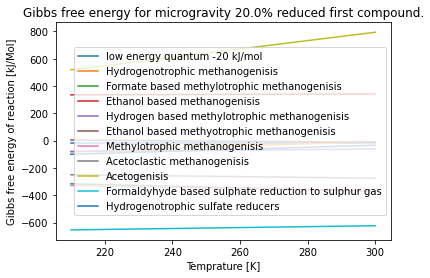

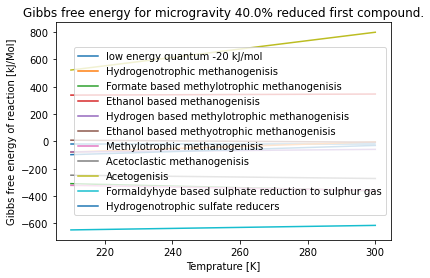

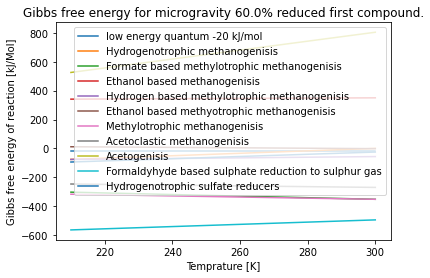

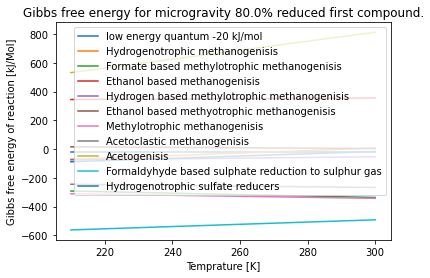

In [34]:
#for plotting microgravity effects
T_min = 210
T_max = 300
steps = 5
dGt_T = np.zeros([len(reactions), 5, 50])


for i in range(len(reactions)):
    dGt_T[i] =  MRA.thin_film_simulation(reactions[i], title = titles[i], steps = steps, C_diff = 0.2, Tmin = T_min, Tmax = T_max, warnings = False, show = 'd_out' )

T = np.linspace(T_min, T_max, np.shape(dGt_T)[-1])

for y in range(steps):
    plt.figure()
    plt.title(f'Gibbs free energy for microgravity {y/0.05}% reduced first compound.')
    plt.plot((T[0], T[-1]),(-20, -20), label = 'low energy quantum -20 kJ/mol') #based on Müller et al 2017, less is possible, but no figure is given for this.

    for i in range(len(reactions)):
        plt.plot(T, dGt_T[i, y, :], label = titles[i])
    
    plt.ylabel("Gibbs free energy of reaction [kJ/Mol]")
    plt.xlabel("Temprature [K]")
    plt.legend()
    plt.savefig(f'GFE_C_range_uG_{y/0.05}_leg.png')